In [1]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import folium

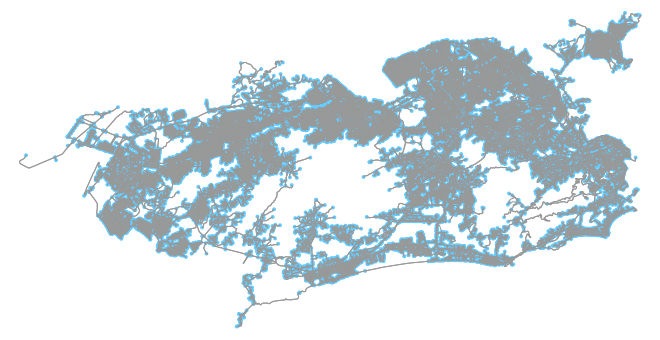

In [2]:
# get a graph for some city
G = ox.graph_from_place('Rio de Janeiro, Rio de Janeiro, Brazil', network_type='drive')
fig, ax = ox.plot_graph(G)

In [7]:
ox.get_nearest_edges(G, X=[-22.8836], Y=[-43.49522])

array([[616220627, 611703423]])

In [4]:
nodes, edges = ox.graph_to_gdfs(G)
edges.columns

Index(['access', 'area', 'bridge', 'geometry', 'highway', 'junction', 'key',
       'lanes', 'length', 'maxspeed', 'name', 'oneway', 'osmid', 'ref',
       'service', 'tunnel', 'u', 'v', 'width'],
      dtype='object')

In [5]:
edges[(edges.u==616220627)&(edges.v==611703423)]

,access,area,bridge,geometry,highway,junction,key,lanes,length,maxspeed,name,oneway,osmid,ref,service,tunnel,u,v,width
58924,NaN,NaN,NaN,"LINESTRING (-43.4955522 -22.882686, -43.494849...",primary,NaN,0,2,382.323,NaN,Avenida Santa Cruz,True,257016545,NaN,NaN,NaN,616220627,611703423,NaN


In [89]:
edges[edges.name=='Rua Carmem Cinira']['length'].sum()/1000

4.0362089999999995

In [101]:
edges.geometry[0].within(point)

False

In [1]:
from h3 import h3

def visualize_hexagons(hexagons, color="red", folium_map=None):
    """
    hexagons is a list of hexcluster. Each hexcluster is a list of hexagons. 
    eg. [[hex1, hex2], [hex3, hex4]]
    """
    polylines = []
    lat = []
    lng = []
    for hex in hexagons:
        polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
        # flatten polygons into loops.
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        lat.extend(map(lambda v:v[0],polyline))
        lng.extend(map(lambda v:v[1],polyline))
        polylines.append(polyline)
    
    if folium_map is None:
        m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron')
    else:
        m = folium_map
    for polyline in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color=color)
        m.add_child(my_PolyLine)
    return m

In [19]:
h3_address = h3.geo_to_h3(-22.883249, -43.495098, 10) # lat, lng, hex resolution
hex_center_coordinates = h3.h3_to_geo(h3_address) # array of [lat, lng]
hex_boundary = h3.h3_to_geo_boundary(h3_address) # array of arrays of [lat, lng]

m = visualize_hexagons([h3_address])
display(m)

In [ ]:
def kring_smoothing(df, hex_col, metric_col, k):
    dfk = df[[hex_col]] 
    dfk.index = dfk[hex_col]
    dfs =  (dfk[hex_col]
                 .apply(lambda x: pd.Series(list(h3.k_ring(x,k)))).stack()
                 .to_frame('hexk').reset_index(1, drop=True).reset_index()
                 .merge(df[[hex_col,metric_col]]).fillna(0)
                 .groupby(['hexk'])[[metric_col]].sum().divide((1 + 3 * k * (k + 1)))
                 .reset_index()
                 .rename(index=str, columns={"hexk": hex_col}))
    dfs['lat'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfs['lng'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])
    return dfs

In [ ]:
#kring_smoothing

k = 3
df311s = kring_smoothing(df311g, hex_col, metric_col='count', k=k)
print('sum sanity check:', df311s['count'].sum() / df311g['count'].sum())
plot_scatter(df311s, metric_col='count', marker='o', colormap='viridis')
#plt.title('noise complaints: 2-ring average');